<a href="https://colab.research.google.com/github/RoozbehSanaei/deep-learning-notebooks/blob/master/cogan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[**Coupled Generative Adversarial Networks**](https://arxiv.org/abs/1606.07536)

![alt text](https://i.ibb.co/ZBtcbb9/cogan.png)

In [0]:
from __future__ import print_function, division
import scipy

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np
!mkdir images

Using TensorFlow backend.


In [0]:
class COGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.d1, self.d2 = self.build_discriminators()
        self.d1.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        self.d2.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.g1, self.g2 = self.build_generators()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img1 = self.g1(z)
        img2 = self.g2(z)

        # For the combined model we will only train the generators
        self.d1.trainable = False
        self.d2.trainable = False

        # The valid takes generated images as input and determines validity
        valid1 = self.d1(img1)
        valid2 = self.d2(img2)

        # The combined model  (stacked generators and discriminators)
        # Trains generators to fool discriminators
        self.combined = Model(z, [valid1, valid2])
        self.combined.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
                                    optimizer=optimizer)

In [0]:
def build_generators(self):

    # Shared weights between generators
    model = Sequential()
    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    noise = Input(shape=(self.latent_dim,))
    feature_repr = model(noise)

    # Generator 1
    g1 = Dense(1024)(feature_repr)
    g1 = LeakyReLU(alpha=0.2)(g1)
    g1 = BatchNormalization(momentum=0.8)(g1)
    g1 = Dense(np.prod(self.img_shape), activation='tanh')(g1)
    img1 = Reshape(self.img_shape)(g1)

    # Generator 2
    g2 = Dense(1024)(feature_repr)
    g2 = LeakyReLU(alpha=0.2)(g2)
    g2 = BatchNormalization(momentum=0.8)(g2)
    g2 = Dense(np.prod(self.img_shape), activation='tanh')(g2)
    img2 = Reshape(self.img_shape)(g2)

    model.summary()

    return Model(noise, img1), Model(noise, img2)

COGAN.build_generators = build_generators
del build_generators

In [0]:
def build_discriminators(self):

    img1 = Input(shape=self.img_shape)
    img2 = Input(shape=self.img_shape)

    # Shared discriminator layers
    model = Sequential()
    model.add(Flatten(input_shape=self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    img1_embedding = model(img1)
    img2_embedding = model(img2)

    # Discriminator 1
    validity1 = Dense(1, activation='sigmoid')(img1_embedding)
    # Discriminator 2
    validity2 = Dense(1, activation='sigmoid')(img2_embedding)

    return Model(img1, validity1), Model(img2, validity2)

COGAN.build_discriminators = build_discriminators;
del build_discriminators

In [0]:
def sample_images(self, epoch):
    r, c = 4, 4
    noise = np.random.normal(0, 1, (r * int(c/2), 100))
    gen_imgs1 = self.g1.predict(noise)
    gen_imgs2 = self.g2.predict(noise)

    gen_imgs = np.concatenate([gen_imgs1, gen_imgs2])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()

COGAN.sample_images = sample_images;
del sample_images

In [0]:
def train(self, epochs, batch_size=128, sample_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    # Images in domain A and B (rotated)
    X1 = X_train[:int(X_train.shape[0]/2)]
    X2 = X_train[int(X_train.shape[0]/2):]
    X2 = scipy.ndimage.interpolation.rotate(X2, 90, axes=(1, 2))

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ----------------------
        #  Train Discriminators
        # ----------------------

        # Select a random batch of images
        idx = np.random.randint(0, X1.shape[0], batch_size)
        imgs1 = X1[idx]
        imgs2 = X2[idx]

        # Sample noise as generator input
        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a batch of new images
        gen_imgs1 = self.g1.predict(noise)
        gen_imgs2 = self.g2.predict(noise)

        # Train the discriminators
        d1_loss_real = self.d1.train_on_batch(imgs1, valid)
        d2_loss_real = self.d2.train_on_batch(imgs2, valid)
        d1_loss_fake = self.d1.train_on_batch(gen_imgs1, fake)
        d2_loss_fake = self.d2.train_on_batch(gen_imgs2, fake)
        d1_loss = 0.5 * np.add(d1_loss_real, d1_loss_fake)
        d2_loss = 0.5 * np.add(d2_loss_real, d2_loss_fake)


        # ------------------
        #  Train Generators
        # ------------------

        g_loss = self.combined.train_on_batch(noise, [valid, valid])

        # Plot the progress
        print ("%d [D1 loss: %f, acc.: %.2f%%] [D2 loss: %f, acc.: %.2f%%] [G loss: %f]" \
            % (epoch, d1_loss[0], 100*d1_loss[1], d2_loss[0], 100*d2_loss[1], g_loss[0]))

        # If at save interval => save generated image samples
        if epoch % sample_interval == 0:
            self.sample_images(epoch)

COGAN.train = train;
del train

In [0]:
gan = COGAN()
gan.train(epochs=30000, batch_size=32, sample_interval=200)

images/mnist_0.png	images/mnist_18800.png	images/mnist_27800.png
images/mnist_10000.png	images/mnist_19000.png	images/mnist_28000.png
images/mnist_1000.png	images/mnist_19200.png	images/mnist_2800.png
images/mnist_10200.png	images/mnist_19400.png	images/mnist_28200.png
images/mnist_10400.png	images/mnist_19600.png	images/mnist_28400.png
images/mnist_10600.png	images/mnist_19800.png	images/mnist_28600.png
images/mnist_10800.png	images/mnist_20000.png	images/mnist_28800.png
images/mnist_11000.png	images/mnist_2000.png	images/mnist_29000.png
images/mnist_11200.png	images/mnist_200.png	images/mnist_29200.png
images/mnist_11400.png	images/mnist_20200.png	images/mnist_29400.png
images/mnist_11600.png	images/mnist_20400.png	images/mnist_29600.png
images/mnist_11800.png	images/mnist_20600.png	images/mnist_29800.png
images/mnist_12000.png	images/mnist_20800.png	images/mnist_3000.png
images/mnist_1200.png	images/mnist_21000.png	images/mnist_3200.png
images/mnist_12200.png	images/mnist_21200.png	

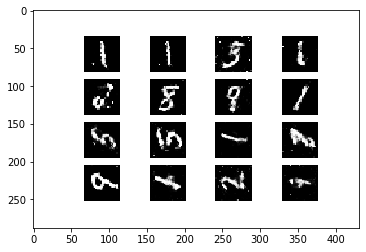

In [0]:
! ls images/*
img = plt.imread("images/mnist_29800.png")
plt.imshow(img)